In [120]:
import pandas as pd
from plotly.offline import init_notebook_mode,iplot
init_notebook_mode(connected=True)
from plotly.graph_objects import * 
import warnings
from sklearn.metrics import mean_absolute_error, r2_score
warnings.filterwarnings('ignore')
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing   

from statsmodels.tsa.holtwinters import ExponentialSmoothing
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
# Use seaborn style defaults and set the default figure size
sns.set(rc={'figure.figsize':(15, 10)})
sns.set(font_scale=2)
sns.set_style("whitegrid")
sns.set_context("talk")

Загрузка данных
=====

In [99]:
df = pd.read_csv('C://Users/Ulia/Untitled Folder/Forecasting-and-Time-Series-2ed-main/datatest/monthly-car-sales.csv')

In [100]:
df.head()

,Month,Sales
0,1960-01,6550
1,1960-02,8728
2,1960-03,12026
3,1960-04,14395
4,1960-05,14587


Создадим серию, у которой в качестве индекса будет Month, а в качестве значений - количество продаж Sales

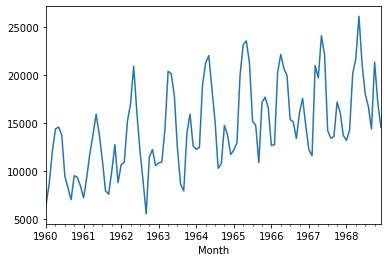

In [101]:
df['Month']=pd.to_datetime(df['Month'])
df.set_index('Month',inplace=True)
s = df['Sales']
s.index.freq = 'MS'
s.plot()
plt.show()

In [102]:
s.head()

Month
1960-01-01     6550
1960-02-01     8728
1960-03-01    12026
1960-04-01    14395
1960-05-01    14587
Freq: MS, Name: Sales, dtype: int64

Задание №1
===

Разделить данные на train и test, оставив на test два года

In [103]:
# your code 
train, test = s[0:-24], s[-24:]

In [104]:
train.head()

Month
1960-01-01     6550
1960-02-01     8728
1960-03-01    12026
1960-04-01    14395
1960-05-01    14587
Freq: MS, Name: Sales, dtype: int64

Задание №2
===

* Создать модель <code> SimpleExpSmoothing </code>
* Натренировать ее на train данных
* Сделать предсказания как для train, так и для test
* Выбрать метрики и посчитать качества предсказаний для train и для test
* Построить графики, на которых будут как реальные данные, так и предсказания




In [105]:
s_train = train.copy()
s_train_12 = train.copy()
s_test = test.copy()

preds_test = list()
preds_train = list()

for i in range(len(test)):
    mod = SimpleExpSmoothing(s_train)
    preds_test.append(mod.fit(smoothing_level=0.8,optimized=False).forecast(1).values[0])
    s_train = pd.concat([s_train,s_test[i:i+1]])

for i in range(len(train)):
    mod = SimpleExpSmoothing(s_train_12)
    preds_train.append(mod.fit(smoothing_level=0.8,optimized=False).forecast(1).values[0])
    s_train_12 = pd.concat([s_train_12,s_train_12[i:i+1]])    
    
test_score = round(r2_score(test, preds_test),4)
train_score = round(r2_score(train, preds_train),4)
    
trace1 = Scatter(x=s.index,y=s.values,name='Original dataset')
trace2 = Scatter(x=test.index,y=preds_test, name = f'Predictions for test, r2_score={test_score}')
trace3 = Scatter(x=train.index, y=preds_train, name = f'Predictions for train, r2_score={train_score}')

iplot(Figure(data=[trace1, trace2,trace3]))

Задание №3
===
* Построить модели двойного и тройного экспоненциального сглаживания
* Так же, как и в предыдущем задании, посчитать метрики для train и test
* Построить график

In [106]:
s_train_2 = train.copy()
s_test_2 = test.copy()
s_train_22 = train.copy()

preds_test_2 = list()
preds_train_2 = list()

for i in range(len(test)):
    mod = ExponentialSmoothing(s_train_2, trend='mul')
    preds_test_2.append(mod.fit(smoothing_level=0.8).forecast(2).values[0])
    s_train_2 = pd.concat([s_train_2,s_test[i:i+2]])

for i in range(len(train)):
    mod = ExponentialSmoothing(s_train_22, trend='mul')
    preds_train_2.append(mod.fit(smoothing_level=0.8).forecast(2).values[0])
    s_train_22 = pd.concat([s_train_22, s_train_22[i:i+2]])
    
test_score_2 = round(r2_score(test, preds_test_2),4)
train_score_2 = round(r2_score(train, preds_train_2),4)

trace1 = Scatter(x=s.index,y=s.values,name='Original dataset')
trace2 = Scatter(x=test.index,y=preds_test_2, name = f'Predictions for double test, r2_score={test_score_2}')
trace3 = Scatter(x=train.index, y=preds_train_2, name = f'Predictions for double train, r2_score={train_score_2}')

iplot(Figure(data=[trace1, trace2, trace3]))

In [107]:
mod_3 = ExponentialSmoothing(train, trend='add', seasonal='add',seasonal_periods=12)
mod_fit_3 = mod_3.fit(smoothing_level=0.8)

predictions_3 = mod_fit_3.forecast(len(test))
predictions_3_train = mod_fit_3.forecast(len(train))

test_score_3 = round(r2_score(test, predictions_3),4)
train_score_3 = round(r2_score(train, predictions_3_train),4)

trace1 = Scatter(x=s.index,y=s.values,name='Original dataset')
trace2 = Scatter(x=test.index,y=predictions_3, name= f'Predictions for tripple test, r2_score={test_score_3}')
trace3 = Scatter(x=train.index, y=predictions_3_train, name = f'Predictions for tripple train, r2_score={train_score_3}')


iplot(Figure(data=[trace1, trace2, trace3]))

Задание №4
* Выбрать модель с наиболее подходящими параметрами среди предыдущих 
* Сделать цикл кросс-валидации, где размер test равен одному году
* Посчитать среднее значение выбранных метрик

# For double smoothing

In [110]:
test_size = 12
n_splits = 5 
size = len(s)

In [202]:
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)
r2_list2_double = list()


for train_index, test_index in tscv.split(s):

    X_train, X_test = s[train_index], s[test_index]
    preds_test_2 = list()
        
    for i in range(len(X_test)):
        
        mod = ExponentialSmoothing(X_train, trend='mul')
        preds_test_2.append(mod.fit(smoothing_level=0.8).forecast(2).values[0])
        X_train = pd.concat([X_train,X_test[i:i+2]])
    r2_list2_double.append(r2_score(X_test,preds_test_2))
    

    
    trace1 = Scatter(x=X_train.index,y=X_train.values, name='X_train')
    trace2 = Scatter(x=X_test.index,y=preds_test_2, name= f'Predictions for double test, r2_score={round(r2_score(X_test,preds_test_2),4)}')
   
    iplot(Figure(data=[trace1, trace2]))  
    
       

# For tripple smoothing

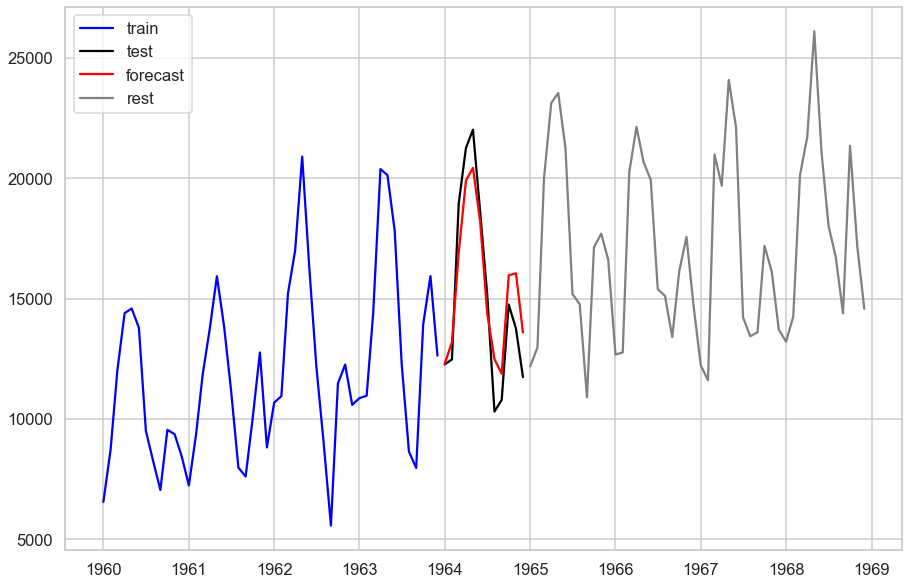

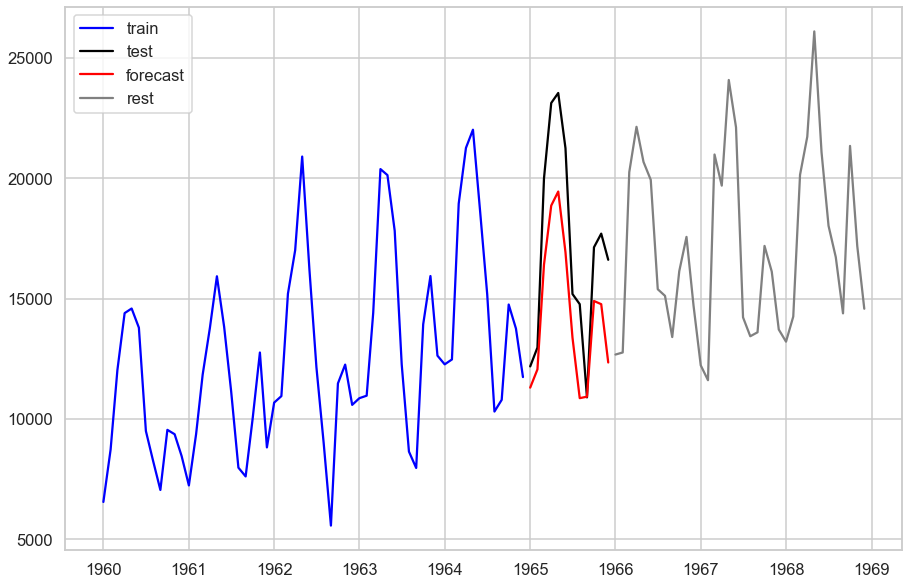

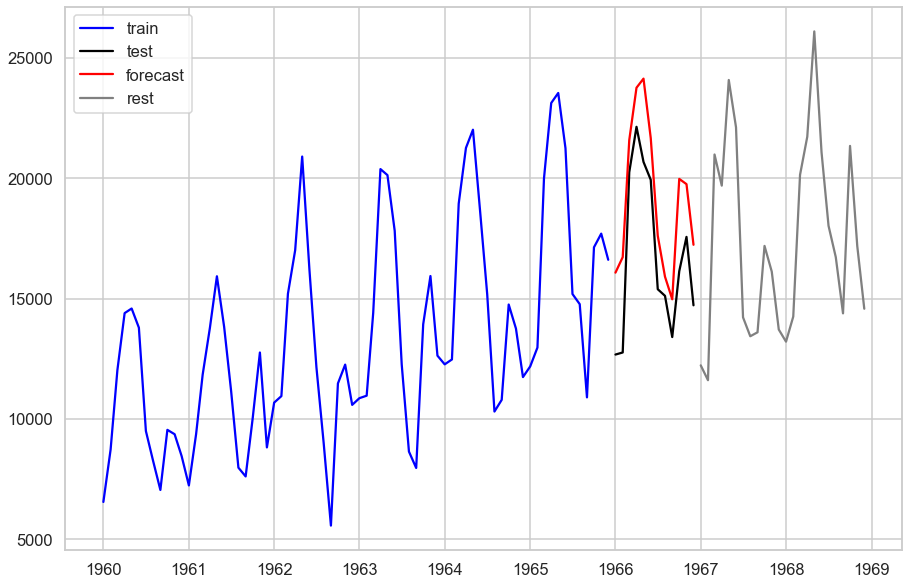

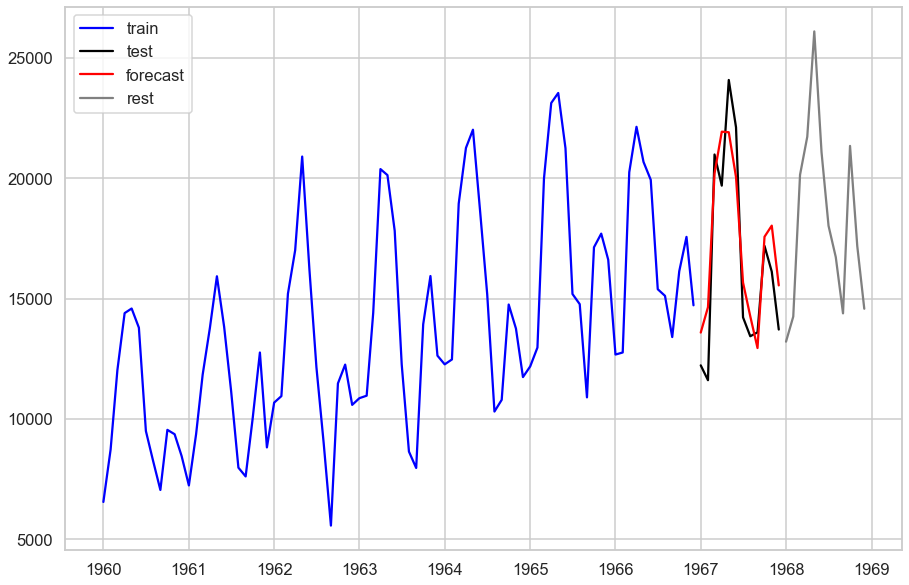

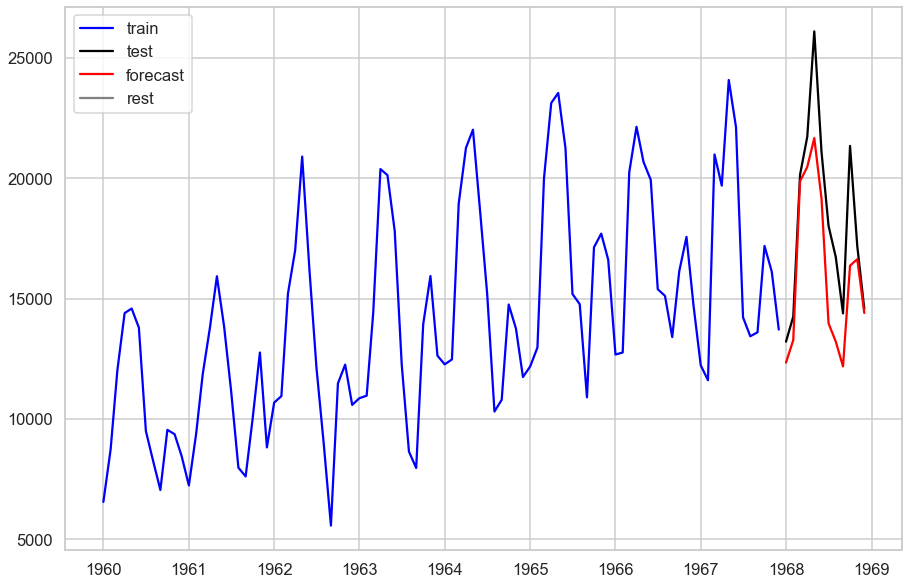

In [179]:
r2_list = list()
for i in reversed(range(n_splits)):
    idx = size - (i+1)*test_size
    train = s[0:idx]
    test = s[idx:idx+test_size]
    rest = s[idx+test_size:]
    preds_test_2 = list()
    
    for j in range(len(test)):
        mod_3 = ExponentialSmoothing(train, trend='add', seasonal='add',seasonal_periods=12)
        mod_fit_3 = mod_3.fit(smoothing_level=0.8)
        predictions_3 = mod_fit_3.forecast(len(test))


    
    fig, ax = plt.subplots()
    ax.plot(train, label='train', c = 'blue')
    ax.plot(test, label = 'test', c = 'black')
    ax.plot(predictions_3, label = 'forecast', c= 'red')
    ax.plot(rest, label = 'rest', c = 'grey')
    ax.legend()
    plt.show()
    r2_list.append(r2_score(test, predictions_3))


In [205]:
print("Mean for cross validation tripple smoothing= ", pd.Series(r2_list).mean())
print("Mean for cross validation double smoothing= ", pd.Series(r2_list2_double).mean() )

Mean for cross validation tripple smoothing=  0.575939015795993
Mean for cross validation double smoothing=  0.7559304229253201
